In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
import random
from sklearn.model_selection import train_test_split

# Limpieza

In [2]:
# Función para hallar los dias entre la fecha de contagio y la fecha muerte o recuperación
def dias(final, inicial):
    if final != pd.NaT:
        dias = final - inicial
        dias = dias.days
    else:
        dias = 0
    return dias

In [3]:
# Función para clasificar categoricamente la edad de los contagiados
def clasificacion_edad(edad):
    if edad < 18:
        resultado = 'menor_edad'
    elif edad <= 28:
        resultado = 'joven'
    elif edad <= 40:
        resultado = 'joven_adulto'
    elif edad <= 60:
        resultado = 'adulto'
    else:
        resultado = 'adulto_mayor'
    return resultado

In [4]:
# Función para clasificar categoricamente los dias de recuperación de los contagiados
def clasificacion_dias(dias, estado):
    if estado != 'Fallecido':
        if dias <= 30:
            resultado = 'defensas_altas'
        elif dias <= 60:
            resultado = 'defensas_medias'
        elif dias <= 90:
            resultado = 'defensas_bajas'
        else:
            resultado = 'sin_defensas'
    else:
        resultado = 'Fallecido'
    return resultado

In [5]:
# Función para clasificar categoricamente los dias de muerte de los contagiados
def clasificacion_dias_muerte(dias, estado):
    if estado == 'Fallecido':
        if dias <= 10:
            resultado = 'muerte_temprana'
        elif dias <= 20:
            resultado = 'muerte_normal'
        elif dias <= 30:
            resultado = 'muerte_tardia'
        else:
            resultado = 'muerte_prolongada'
    else:
        resultado = 'sobrevivio'
    return resultado

In [6]:
labels = ['edad', 'unidad_medida_edad', 'sexo', 'tipo_contagio', 'ubicacion_caso', 'estado', 'recuperado', 'tipo_recuperacion', 'pertenencia_etnica', 'tipo_ciudad', 'continente', 'region', 'dias_muerte', 'dias_recuperacion', 'edad_categorica' ]

In [7]:
pais_continente = [['arabia saudí', 'arabia saudita'],
    ['belarusia', 'bielorrusia'],
    ['curazao', 'panamá'],
    ['emiratos arabes unidos', 'emiratos árabes unidos'],
    ['federación de rusia', 'rusia'],
    ['kenya', 'kenia'],
    ['libano', 'líbano'],
    ['mexico', 'méxico'],
    ['panama', 'panamá'],
    ['peru', 'perú'],
    ['reino unido de gran bretaña e irlanda del norte', 'reino unido'],
    ['república de corea', 'corea del sur'],
    ['república docimincana', 'república dominicana'],
    ['república árabe siria', 'siria'],
    ['santa helena', 'santa elena'],
    ['tabatinga', 'brasil'],
    ['veneuela', 'venezuela']
]

In [8]:
departamentos = [['BARRANQUILLA','ATLANTICO'],
                ['BOGOTA','CUNDINAMARCA'],
                ['CARTAGENA','BOLIVAR'],
                ['GUAJIRA','LA GUAJIRA'],
                ['NORTE SANTANDER','NORTE DE SANTANDER'],
                ['SAN ANDRES','ARCHIPIELAGO DE SAN ANDRES, PROVIDENCIA Y SANTA CATALINA'],
                ['STA MARTA D.E.','MAGDALENA'],
                ['VALLE','VALLE DEL CAUCA']]

In [9]:
# Se cargan los archivos uno con casos de Covid en Colombia, otro con paises y sus continentes, otro con departamentos y sus regiones
casos = pd.read_csv('Casos_positivos_de_COVID-19_en_Colombia.csv')
paises = pd.read_csv('paises.csv')
regiones = pd.read_csv('DIVIPOLA_Departamentos.csv',sep=';', error_bad_lines=False, encoding= 'unicode_escape')

C:\Users\ctobon\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3146: DtypeWarning: Columns (13,14,22) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [10]:
# Con la función de mapeo se homologan las clases que tienen el mismo significado
casos.loc[:, 'Sexo'] = casos.Sexo.map({'F':'F', 'f':'F', 'M':'M', 'm':'M'})
casos.loc[:, 'Ubicación del caso'] = casos['Ubicación del caso'].map({'Casa':'Casa', 'casa':'Casa', 'CASA':'Casa', 'Fallecido':'Fallecido', 'Hospital':'Hospital', 'Hospital UCI':'Hospital_UCI'})
casos.loc[:, 'Estado'] = casos.Estado.map({'Leve':'Leve', 'LEVE':'Leve', 'leve':'Leve', 'Fallecido':'Fallecido', 'Moderado':'Moderado', 'Grave':'Grave'})
casos.loc[:, 'Recuperado'] = casos.Recuperado.map({'Recuperado':'Recuperado', 'Activo':'Activo', 'Fallecido':'Fallecido', 'fallecido':'Fallecido'})

# Se determina si la ciudad es capital o no capital
casos['Capital'] = casos['Código DIVIPOLA municipio'].apply(lambda x : 'Capital' if x[-2:]=='01' else 'No_Capital')

# Se limpia la variable 'Nombre del país' para luego utilizar un ciclo for y traer el nombre de los paises escritos de forma diferente
casos['Nombre del país'].fillna("no_aplica", inplace=True)
casos.loc[:, 'Nombre del país'] = casos['Nombre del país'].apply(lambda x : x.lower())
paises.loc[:, 'nombre'] = paises['nombre'].apply(lambda x : x.lower())
for i, pais in enumerate(pais_continente):
    casos['Nombre del país'].mask(casos['Nombre del país']==pais_continente[i][0], pais_continente[i][1], inplace=True)

# Se utiliza ciclo for para traer el nombre de los departamentos escritos de forma diferente
for j, departamento in enumerate(departamentos):
    casos['Nombre departamento'].mask(casos['Nombre departamento']==departamentos[j][0], departamentos[j][1], inplace=True)

# Con la función merge se traen los nombres de los continentes y de las regiones naturales
casos = pd.merge(casos, paises[['nombre', 'continente']], left_on='Nombre del país', right_on='nombre', how='left' )
casos['continente'].fillna('no_aplica', inplace=True)
casos = pd.merge(casos, regiones[['NOM_DPTO', 'REGION']], left_on='Nombre departamento', right_on='NOM_DPTO', how='left')
casos['REGION'].fillna('no_aplica', inplace=True)

# Las variables de fecha se convierten a tipo datetime, para poder realizar operaciones de fechas
casos['Fecha de muerte'] = pd.to_datetime(casos['Fecha de muerte'])
casos['Fecha de diagnóstico'] = pd.to_datetime(casos['Fecha de diagnóstico'])
casos['Fecha de inicio de síntomas'] = pd.to_datetime(casos['Fecha de diagnóstico'])
casos['Fecha de recuperación'] = pd.to_datetime(casos['Fecha de recuperación'])
casos['Fecha de inicio de síntomas'] = pd.to_datetime(casos['Fecha de inicio de síntomas'])
casos['Fecha de recuperación'] = pd.to_datetime(casos['Fecha de recuperación'])

# Se aplican las funciones que definimos hallar los dias de muerte y de recuperación
casos['dias_muerte'] = casos.apply(lambda x : dias(x['Fecha de muerte'], x['Fecha de inicio de síntomas']), axis=1)
casos['dias_recuperacion'] = casos.apply(lambda x : dias(x['Fecha de recuperación'], x['Fecha de inicio de síntomas']), axis=1)
casos['dias_muerte'].fillna(0, inplace=True)
casos['dias_recuperacion'].fillna(0, inplace=True)

#Se eliminan las variables que no se van a utilizar o redundantes. se cambian los encabezados
casos.drop(columns=['fecha reporte web', 'Fecha de notificación', 'ID de caso', 'Código DIVIPOLA departamento', 'Nombre departamento', 'Código DIVIPOLA municipio', 'Nombre municipio', 'Código ISO del país', 'Nombre del país', 'Nombre del grupo étnico','nombre', 'NOM_DPTO', 'Fecha de inicio de síntomas', 'Fecha de muerte', 'Fecha de diagnóstico', 'Fecha de recuperación'], inplace=True)
casos.columns = labels

# Se actualizan las clases de la variable 'tipo contagio'
casos['tipo_contagio'] = casos['tipo_contagio'].map({'En estudio':'En_estudio', 'Comunitaria':'Comunitaria', 'Relacionado':'Relacionado','Importado':'Importado'})
casos.fillna('no_aplica', inplace=True)

# Se aplican las funciones que definimos para convertir variables a categoricas
casos['edad_categorica'] = casos['Edad'].apply(lambda x : clasificacion_edad(x))
casos['dias_recuperacion_cat'] = casos.apply(lambda x : clasificacion_dias(x['dias_recuperacion'], x['estado']), axis=1)
casos['dias_muerte_cat'] = casos.apply(lambda x : clasificacion_dias_muerte(x['dias_muerte'], x['estado']), axis=1)

In [11]:
#Se filtran los datasets y se generan los archivos con extensión csv
casos_resumido = casos[(casos.tipo_contagio != 'no_aplica') &
                       (casos.ubicacion_caso != 'no_aplica') &
                       (casos.estado != 'no_aplica') &
                       (casos.recuperado != 'no_aplica') 
                       ]
casos_muerte = casos[casos.estado == 'Fallecido']
casos_train, casos_test, y_train, y_test = train_test_split(casos_resumido, casos_resumido['edad'], test_size=0.7, random_state=42)
casos_muerte.to_csv('casos_muerte.csv')
casos.to_csv('casos_covid.csv')
casos_train.to_csv('casos_train.csv')
casos_train.to_csv('casos_train.csv')

In [12]:
for x in labels:
    print(casos_resumido[x].value_counts())

30     65185
28     64727
29     64577
31     63185
26     63179
       ...  
108        6
109        2
110        2
113        1
114        1
Name: edad, Length: 112, dtype: int64
1    2566524
2       7780
3        964
Name: unidad_medida_edad, dtype: int64
F    1331145
M    1244123
Name: sexo, dtype: int64
En_estudio     1287424
Comunitaria     818545
Relacionado     466305
Importado         2994
Name: tipo_contagio, dtype: int64
Casa            2493821
Fallecido         66819
Hospital          11892
Hospital_UCI       2736
Name: ubicacion_caso, dtype: int64
Leve         2493821
Fallecido      66819
Moderado       11892
Grave           2736
Name: estado, dtype: int64
Recuperado    2417570
Activo          90879
Fallecido       66819
Name: recuperado, dtype: int64
Tiempo       2113147
PCR           304423
no_aplica     157698
Name: tipo_recuperacion, dtype: int64
6.0          2377222
no_aplica      93688
5.0            64208
1.0            39683
3.0              403
2.0               6

In [13]:
for x in labels:
    print(casos[x].value_counts())

30     65225
28     64782
29     64623
31     63231
26     63225
       ...  
108        7
109        2
110        2
113        1
114        1
Name: edad, Length: 112, dtype: int64
1    2577001
2       7826
3        974
Name: unidad_medida_edad, dtype: int64
F    1335652
M    1250149
Name: sexo, dtype: int64
En_estudio     1290993
Comunitaria     823937
Relacionado     467871
Importado         3000
Name: tipo_contagio, dtype: int64
Casa            2493821
Fallecido         66819
Hospital          11892
no_aplica         10533
Hospital_UCI       2736
Name: ubicacion_caso, dtype: int64
Leve         2493821
Fallecido      66819
Moderado       11892
no_aplica      10533
Grave           2736
Name: estado, dtype: int64
Recuperado    2419265
Activo          90879
Fallecido       66819
no_aplica        8838
Name: recuperado, dtype: int64
Tiempo       2113147
PCR           306118
no_aplica     166536
Name: tipo_recuperacion, dtype: int64
6.0          2387173
no_aplica      93720
5.0            

In [15]:
casos_resumido.head(2)

,edad,unidad_medida_edad,sexo,tipo_contagio,ubicacion_caso,estado,recuperado,tipo_recuperacion,pertenencia_etnica,tipo_ciudad,continente,region,dias_muerte,dias_recuperacion,edad_categorica,dias_recuperacion_cat,dias_muerte_cat
0,19,1,F,Importado,Casa,Leve,Recuperado,PCR,6,Capital,Europa,Andina,0.0,-82.0,joven,defensas_altas,sobrevivio
1,34,1,M,Importado,Casa,Leve,Recuperado,PCR,5,No_Capital,Europa,Andina,0.0,-168.0,joven_adulto,defensas_altas,sobrevivio


# Exploración 

In [16]:
listado = ['recuperado', 'estado', 'region', 'ubicacion_caso', 'tipo_contagio', 'tipo_ciudad']
listado_region = ['recuperado', 'estado', 'sexo', 'ubicacion_caso', 'tipo_contagio', 'tipo_ciudad']

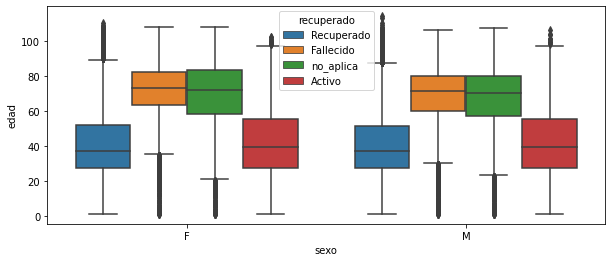

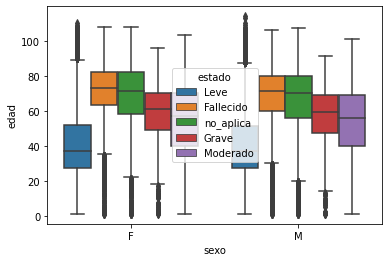

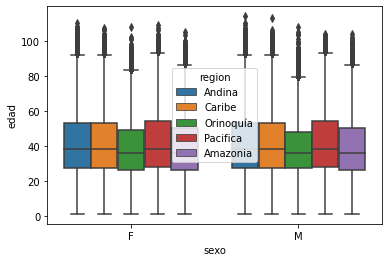

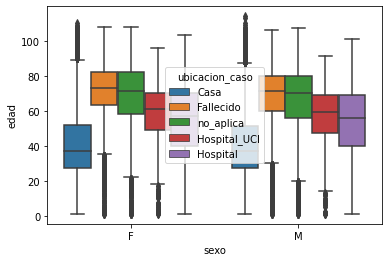

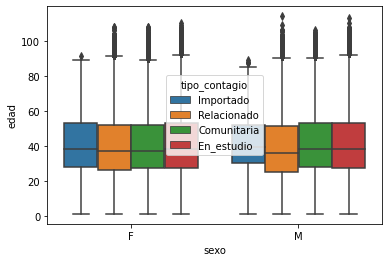

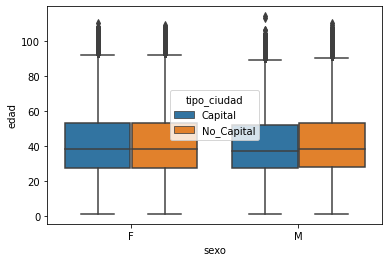

In [17]:
plt.figure(figsize=(10, 4))
for x in listado:
    sns.boxplot(x='sexo', y='edad', hue=x, data=casos)
    plt.title('')
    plt.show()

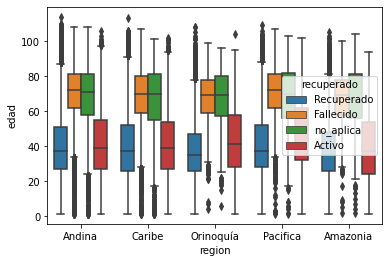

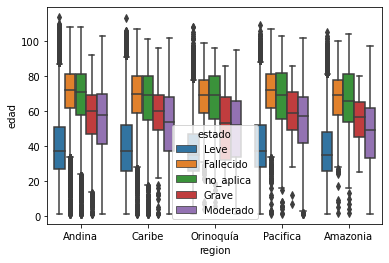

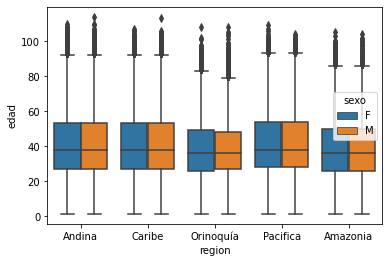

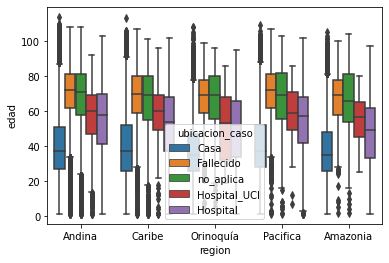

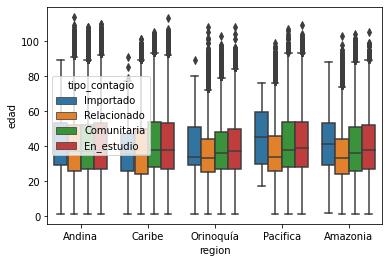

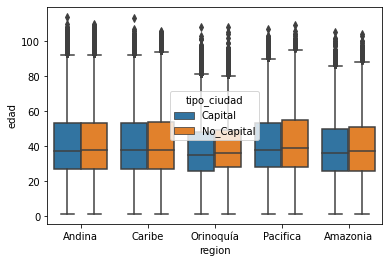

In [18]:
for x in listado_region:
    sns.boxplot(x='region', y='edad', hue=x, data=casos)
    plt.title('')
    plt.show()

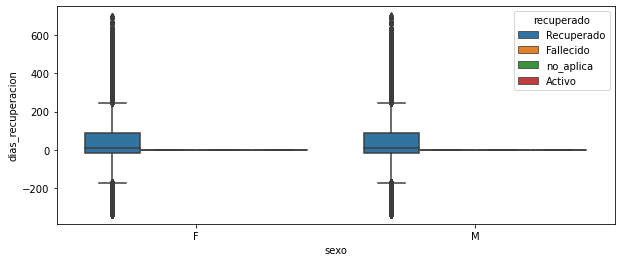

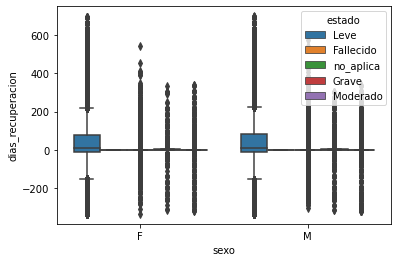

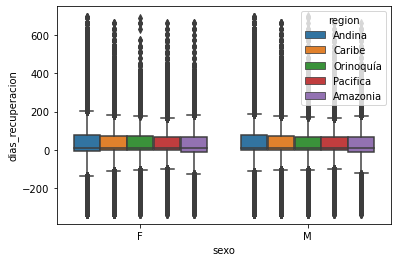

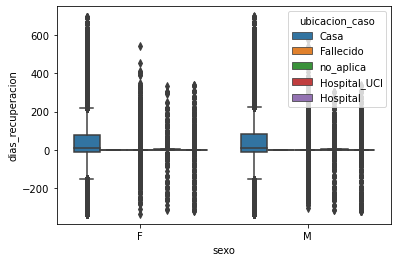

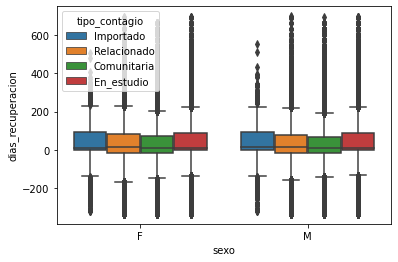

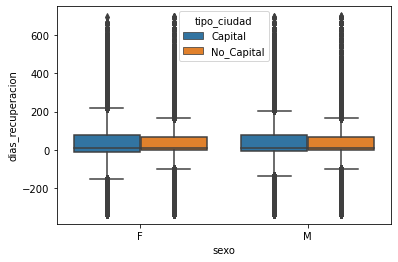

In [19]:
plt.figure(figsize=(10, 4))
for x in listado:  
    sns.boxplot(x='sexo', y='dias_recuperacion', hue=x, data=casos)
    plt.show()

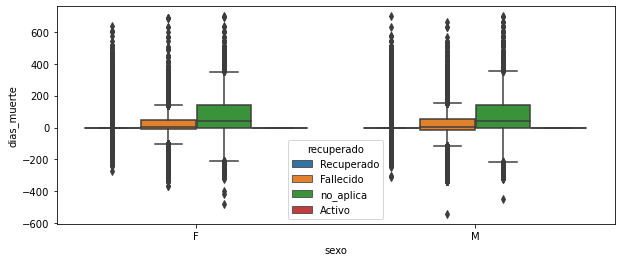

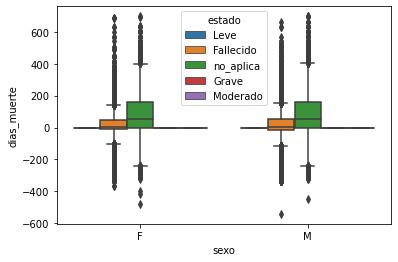

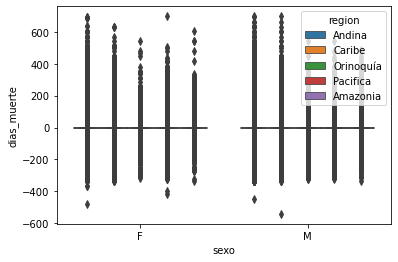

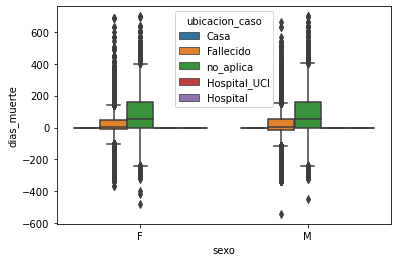

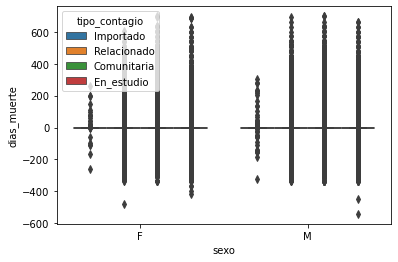

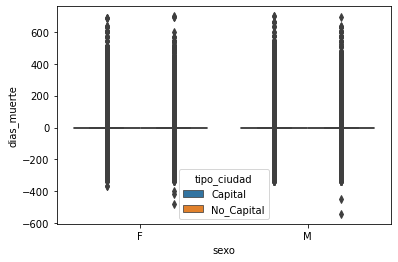

In [20]:
plt.figure(figsize=(10, 4))
for x in listado:  
    sns.boxplot(x='sexo', y='dias_muerte', hue=x, data=casos)
    plt.show()

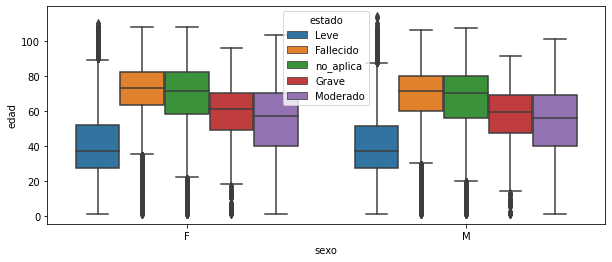

In [21]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='sexo', y='edad', hue='estado', data=casos)
plt.title('')
plt.show()

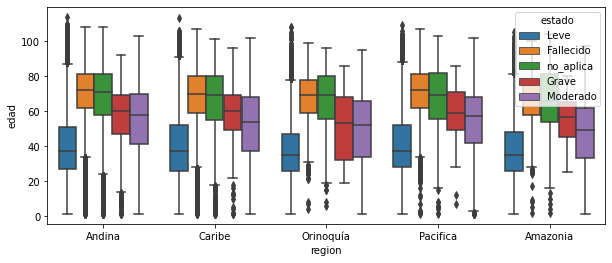

In [22]:
plt.figure(figsize=(10, 4))
sns.boxplot(x='region', y='edad', hue='estado', data=casos)
plt.title('')
plt.show()

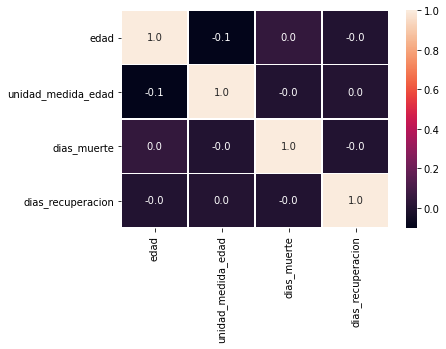

In [23]:
plt.figure()
sns.heatmap(casos.corr(), annot=True, linewidth=0.5, fmt='.1f')
plt.show()

C:\Users\ctobon\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


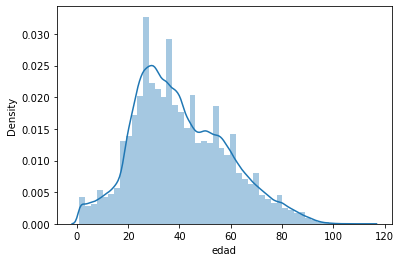

In [24]:
plt.figure()
sns.distplot(casos['edad'])
plt.show()

C:\Users\ctobon\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


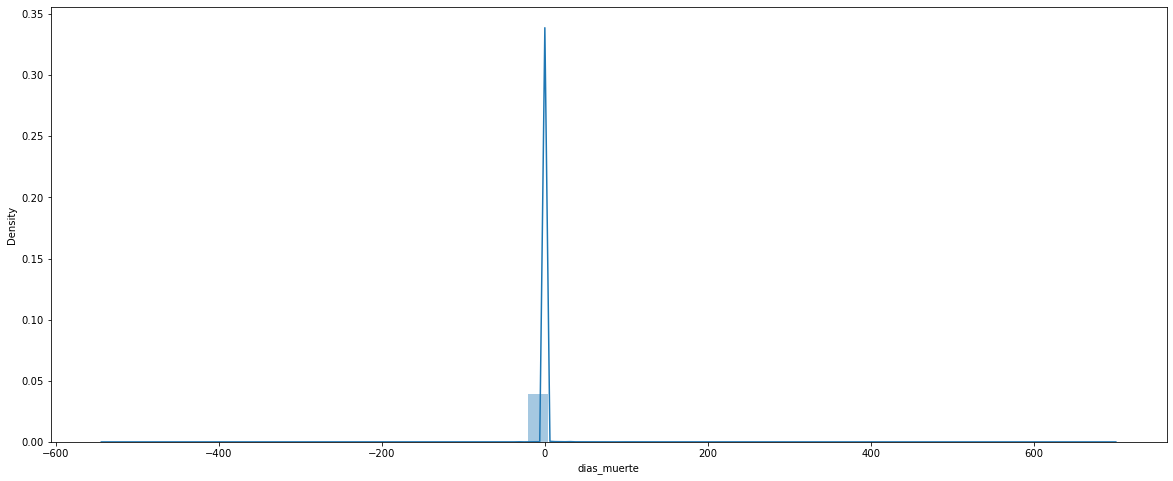

In [25]:
plt.figure(figsize=(20, 8))
sns.distplot(casos['dias_muerte'])
plt.show()

C:\Users\ctobon\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


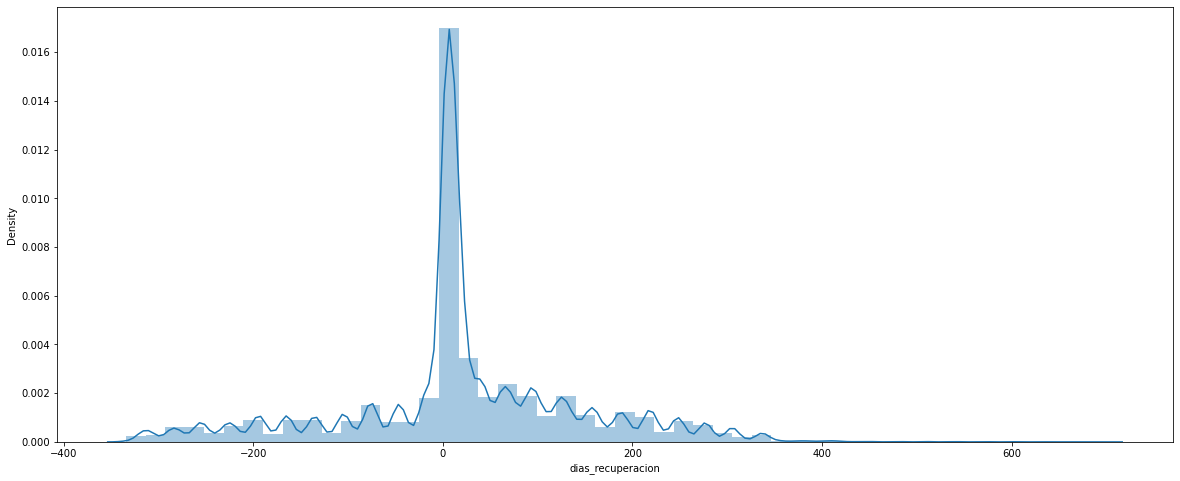

In [26]:
plt.figure(figsize=(20,8))
sns.distplot(casos['dias_recuperacion'])
plt.show()

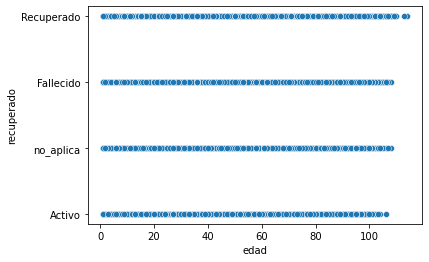

In [27]:
plt.figure()
sns.scatterplot(x='edad', y='recuperado', data=casos)
plt.show()

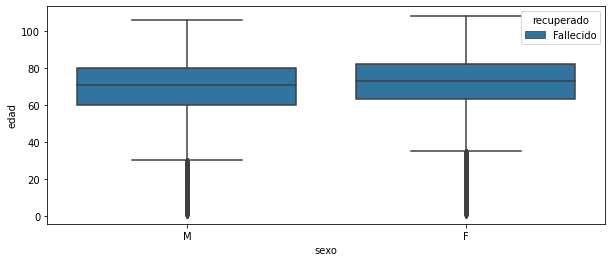

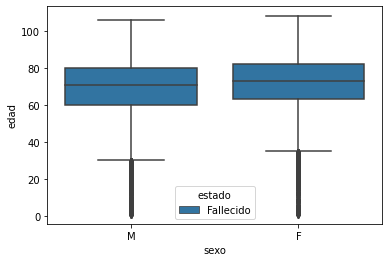

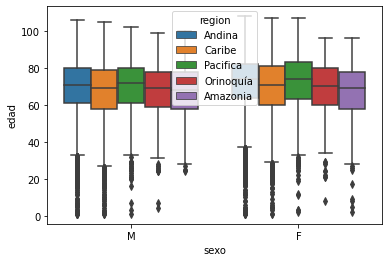

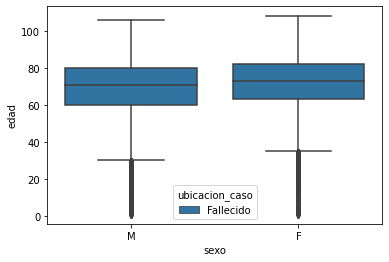

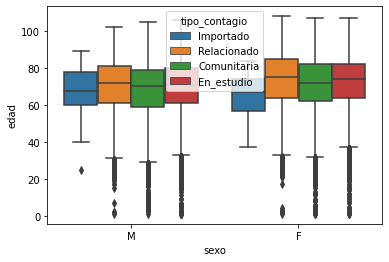

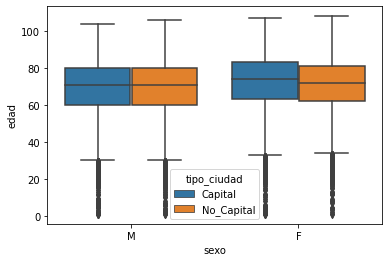

In [28]:
plt.figure(figsize=(10, 4))
for x in listado:
    sns.boxplot(x='sexo', y='edad', hue=x, data=casos[casos['estado']=='Fallecido'])
    plt.title('')
    plt.show()